La commande ci-dessous installe notre code dans l'environnement python de Colab en le clonant à partir de GitHub.

In [1]:
!pip uninstall -y yawbcc
!pip install git+https://github.com/corralien/yawbcc.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/corralien/yawbcc.git to /tmp/pip-req-build-67l_a_n0
  Running command git clone -q https://github.com/corralien/yawbcc.git /tmp/pip-req-build-67l_a_n0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for yawbcc: filename=yawbcc-0.1.0-py3-none-any.whl size=6019 sha256=a8ed656189ce3be32304d3195eba9a38fc867cc6c44abaf8dbcba7ae828afd06
  Stored in directory: /tmp/pip-ephem-wheel-cache-498pjuls/wheels/3a/21/90/7da3f4fa36252d75b866614ee15de27ec23f4a14eed4e416d4
Successfully built yawbcc


Une fois que le package est installé, il est possible d'accéder aux modules et à leurs fonctions.

In [2]:
from yawbcc.datasets import load_barcelona_wbc
meta = load_barcelona_wbc()
meta.head()

,image,group,label,width,height,path
0,EO_692915.jpg,EOSINOPHIL,EO,360,363,/root/yawbcc_data/barcelona/eosinophil/EO_6929...
1,EO_685778.jpg,EOSINOPHIL,EO,360,363,/root/yawbcc_data/barcelona/eosinophil/EO_6857...
2,EO_294378.jpg,EOSINOPHIL,EO,360,363,/root/yawbcc_data/barcelona/eosinophil/EO_2943...
3,EO_162984.jpg,EOSINOPHIL,EO,360,363,/root/yawbcc_data/barcelona/eosinophil/EO_1629...
4,EO_923779.jpg,EOSINOPHIL,EO,360,363,/root/yawbcc_data/barcelona/eosinophil/EO_9237...


In [3]:
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

DATA_DIR = pathlib.Path.home() / 'yawbcc_data'

train_ds = image_dataset_from_directory(DATA_DIR / 'barcelona', validation_split=0.2, subset='training', seed=2022,
                                        image_size=(28, 28), batch_size=128, crop_to_aspect_ratio=True)

valid_ds = image_dataset_from_directory(DATA_DIR / 'barcelona', validation_split=0.2, subset='validation', seed=2022,
                                        image_size=(28, 28), batch_size=128, crop_to_aspect_ratio=True)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


In [4]:
# Séparer variables explicatives / variable cible

X = meta.drop("group", axis = 1)

Y = meta['group']

In [5]:
# Train and testing split

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42) 

In [6]:
# Architecture du modèle LeNet
# Instanciation du modèle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, MaxPool2D

lenet = Sequential()

lenet.add(Conv2D(filters = 25,                   # Nombre de filtres
                kernel_size = (1, 1),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 3),       # Dimensions de l'image en entrée
                activation = 'relu'))            # Fonction d'activation
          
lenet.add(MaxPool2D(strides=2))

lenet.add(Dense(units = 100,
                activation = 'relu'))

lenet.add(Conv2D(filters=30,kernel_size=(1,1),activation="sigmoid",
                padding="valid"))


lenet.add(MaxPool2D(strides=2))

lenet.add(Flatten())

lenet.add(Dense(units = 30,
                activation = 'relu'))

lenet.add(Dense(units = 8,
                activation = 'softmax'))

In [7]:
lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 25)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 25)       0         
 )                                                               
                                                                 
 dense (Dense)               (None, 14, 14, 100)       2600      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 30)        3030      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 30)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1470)              0

In [8]:
lenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
"""
Vu que l'objectif du projet est de prédire l'identification et le classement de différents types de cellules sanguines normales en 8 classes, nous devrions axer nos recherches de métriques dans la catégorie des labels de classe.
Suite à la prédominance d'une classe dans notre dataset, il serait peut être judicieux de privilégier comme métrique de seuil, la matrice de confusion et la mesure du F score (F1 Score, F0,5 Score ou F2 Score à déterminer par la suite), pour quantifier les erreurs de prédiction de classification.

En terme de métriques de classement pour une classification déséquilibrée dans notre dataset, nous pouvons partir sur une analyse des caractéristiques de fonctionnement du récepteur (courbe ROC/analyse ROC) et AUC).
Ces métriques de classement concernent davantage l'évaluation des classificateurs en fonction de leur efficacité à séparer les classes.
Elles nécessitent qu'un classifieur prédise un score ou une probabilité d'appartenance à une classe.
A partir de ce score, différents seuils peuvent être appliqués pour tester l'efficacité des classificateurs. Les modèles qui maintiennent un bon score sur une gamme de seuils auront une bonne séparation des classes et seront mieux classés.
"""

"\nVu que l'objectif du projet est de prédire l'identification et le classement de différents types de cellules sanguines normales en 8 classes, nous devrions axer nos recherches de métriques dans la catégorie des labels de classe.\nSuite à la prédominance d'une classe dans notre dataset, il serait peut être judicieux de privilégier comme métrique de seuil, la matrice de confusion et la mesure du F score (F1 Score, F0,5 Score ou F2 Score à déterminer par la suite), pour quantifier les erreurs de prédiction de classification.\n\nEn terme de métriques de classement pour une classification déséquilibrée dans notre dataset, nous pouvons partir sur une analyse des caractéristiques de fonctionnement du récepteur (courbe ROC/analyse ROC) et AUC).\nCes métriques de classement concernent davantage l'évaluation des classificateurs en fonction de leur efficacité à séparer les classes.\nElles nécessitent qu'un classifieur prédise un score ou une probabilité d'appartenance à une classe.\nA partir d

In [10]:
# Compiler le modèle
lenet.compile(loss='SparseCategoricalCrossentropy',   # fonction de perte pour la classification multiple
              optimizer='adam',                       # algorithme d'optimisation (algorithme de descente de gradient)
              metrics=['accuracy'])                   # métrique d'évaluation

In [15]:
#Entrainement du modèle LeNet

epochs=20
training_history_lenet = lenet.fit(
            train_ds,                        
            validation_data = valid_ds,        
            epochs = epochs,                           
            )

Epoch 1/20
107/107 [==============================] - 16s 144ms/step - loss: 0.7800 - accuracy: 0.7541 - val_loss: 0.6714 - val_accuracy: 0.7888
Epoch 2/20
107/107 [==============================] - 16s 145ms/step - loss: 0.6229 - accuracy: 0.7982 - val_loss: 0.5665 - val_accuracy: 0.8306
Epoch 3/20
107/107 [==============================] - 16s 145ms/step - loss: 0.5467 - accuracy: 0.8161 - val_loss: 0.5080 - val_accuracy: 0.8487
Epoch 4/20
107/107 [==============================] - 17s 146ms/step - loss: 0.4961 - accuracy: 0.8327 - val_loss: 0.4549 - val_accuracy: 0.8482
Epoch 5/20
107/107 [==============================] - 16s 144ms/step - loss: 0.4601 - accuracy: 0.8435 - val_loss: 0.4608 - val_accuracy: 0.8470
Epoch 6/20
107/107 [==============================] - 16s 140ms/step - loss: 0.4314 - accuracy: 0.8556 - val_loss: 0.4204 - val_accuracy: 0.8616
Epoch 7/20
107/107 [==============================] - 17s 152ms/step - loss: 0.4167 - accuracy: 0.8574 - val_loss: 0.4152 - val_ac

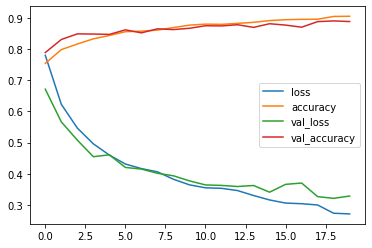

In [38]:
import pandas as pd
pd.DataFrame(training_history_lenet.history).plot();

In [16]:
# évaluation performance du modèle : extraire de training_history_lenet les précisions sur les bases d'entraînement et de test obtenues pendant l'entraînement

train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

In [29]:
train_loss_lenet = training_history_lenet.history['loss']
val_loss_lenet = training_history_lenet.history['val_loss']

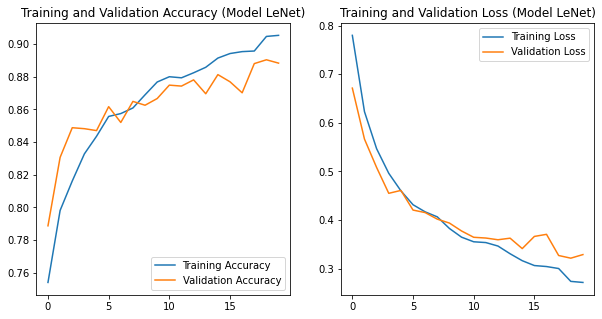

In [39]:
import matplotlib.pyplot as plt

epochs=20
epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_lenet, label='Training Accuracy')
plt.plot(epochs_range, val_acc_lenet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model LeNet)');

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_lenet, label='Training Loss')
plt.plot(epochs_range, val_loss_lenet, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model LeNet)')
plt.show();

In [46]:
# Prédire les classes de l'échantillon X_test à l'aide de la méthode predict du modèle LeNet. Stocker le résultat dans un tableau nommé test_pred_lenet.
# Appliquer la méthode argmax sur les tableaux test_pred_lenet et y_test pour obtenir des vecteurs d'entiers correspondant aux classes prédites et réelles. Il faudra passer l'argument 'axis = 1' pour que l'argmax soit calculée sur les colonnes et non les lignes. Stocker les sorties des appels de la méthode argmax dans des tableaux nommés test_pred_lenet_class et y_test_class.

import numpy as np

X_test = np.asarray(X_test).astype(np.float32)

test_pred_lenet = lenet.predict(X_test)

test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)

y_test_class = Y_test.argmax(axis = 1)

ValueError: ignored

In [33]:
from sklearn.metrics import confusion_matrix

# Calcul et affichage de la matrice de confusion
matrice_confusion = confusion_matrix(Y_test, test_pred_lenet)
print("Matrice de Confusion:\n",  matrice_confusion)

print("\nLe modèle LeNet a fait", matrice_confusion[0, 1], "Faux Positifs.")

# Calcul de l'accuracy, precision et rappel
(VN, FP), (FN, VP) = confusion_matrix(Y_test, test_pred_lenet)
n = len(y_test)

print("\nLenet Accuracy:", (VP + VN) / n)

print("\nLenet Précision:", VP / (VP + FP))

print("\nLenet Rappel:", VP / (VP + FN))

NameError: ignored

In [34]:
# Afficher un compte-rendu évaluatif détaillé de la perfomance du modèle lenet à l'aide de la fonction classification_report du sous-module metrics de scikit-learn.

print(metrics.classification_report(y_test_class, test_pred_lenet_class))

NameError: ignored

In [35]:
"""
interprétation des résultats

On remarque que la majorité des images sont bien identifiées et bien classées.
Avec un taux de précision dépassant les .....% pour quelques minutes d'entraînement, on peut affirmer que ce modèle a rempli son objectif. 
"""

"\ninterprétation des résultats\n\nOn remarque que la majorité des images sont bien identifiées et bien classées.\nAvec un taux de précision dépassant les .....% pour quelques minutes d'entraînement, on peut affirmer que ce modèle a rempli son objectif. \n"